In [3]:
import os
import cv2
from PIL import Image
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
from dataset import CelebaDataset, transform, augment, inverse_normalize
from model import Discriminator, Generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
set_random_seed(seed=0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 128
LR = 2e-4
BETAS = (0.5, 0.999)
NOISE_DIM = 100
NUM_EPOCHS = 50

In [5]:
celeba_dataset = CelebaDataset(folder_path='../../data/celeba_hq_256', transform=transform, augment=augment)
dataloader = DataLoader(dataset=celeba_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

for x in dataloader:
    print(x.shape)
    break

torch.Size([128, 3, 64, 64])


In [ ]:
G = Generator(noise_dim=NOISE_DIM, input_chanels=3).to(device)
D = Discriminator(input_channels=3).to(device)

if not os.path.exists('weights'):
    os.makedirs('weights')
    
if not os.path.exists('img'):
    os.makedirs('img')


criterion = torch.nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
generated_imgs = []

for epoch in range(NUM_EPOCHS):

    G.train()
    D.train()
    
    g_loss_running = 0
    d_loss_running = 0

    for batch_id, real_batch in enumerate(dataloader):
        
        # -----------------------------------------
        # 1. Update (improve) Discriminator network
        # maximize log(D(x)) + log(1 - D(G(z)))
        # -----------------------------------------

        real_batch = real_batch.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_batch = G(noise)

        d_prob_real = D(real_batch).view(-1)
        d_prob_fake = D(fake_batch).view(-1)
        d_loss_real = criterion(d_prob_real, torch.ones_like(d_prob_real))
        d_loss_fake = criterion(d_prob_fake, torch.zeros_like(d_prob_fake))
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss_running += d_loss.item()

        D.zero_grad()
        d_loss.backward(retain_graph=True) # we will reuse fake_batch in generator below
        d_optimizer.step()

        # ---------------------------------------------------
        # 2. Update (improve) Generator network
        # minimize log(1 - D(G(z))) <-> maximize log(D(G(z)))
        # ---------------------------------------------------
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        d_prob = D(fake_batch).view(-1)
        g_loss = criterion(d_prob, torch.ones_like(d_prob_real))
        g_loss_running += g_loss.item()
        
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if batch_id > 0 and batch_id % 50 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch_id:03d}/{len(dataloader)}",
                # d_loss is the quality of discriminator (the lower the better)
                f"d_loss={d_loss.item():.3f}",
                # g_loss is the quality of generator (the lower the better) 
                f"g_loss={g_loss.item():.3f}",
                # D(x) is the average discriminator outputs for the real batch. 
                # This should start close to 1 and then converge to 0.5 as G gets better.
                f"D(x)={d_prob_real.mean().item():.3f}",  
                # D(G(z)) is the average discriminator outputs for the fake batch. 
                # This should start close to 0 and then converge to 0.5 as G gets better.
                f"D(G(z))={d_prob_fake.mean().item():.3f}",
            )
    
    print('************************************************************************')
    print(
        f"epoch={epoch}",
        f"d_loss={d_loss_running/len(dataloader):.3f}",
        f"g_loss={g_loss_running/len(dataloader):.3f}"
    )
    print('************************************************************************')

    with torch.no_grad():
        
        fake_imgs = G(fixed_noise).detach().cpu()

        fig, axs = plt.subplots(5, 5, figsize=(6,6))
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        axs = axs.flatten()
        for i in range(25):
            axs[i].imshow(inverse_normalize(fake_imgs[i]).permute(1,2,0))
            axs[i].axis('off')
        plt.savefig(f'img/img_epoch{epoch:02d}.png', dpi=300)
        plt.show()
        
torch.save(G.state_dict(), f"weights/g_model_epoch_{epoch:02d}.pt")
torch.save(D.state_dict(), f"weights/d_model_epoch_{epoch:02d}.pt")

# Load model

In [6]:
G = Generator(noise_dim=NOISE_DIM, input_chanels=3).to(device)

state_dict = torch.load(f='weights/g_model_epoch_49.pt', map_location=torch.device(device))
G.load_state_dict(state_dict=state_dict)
G.eval()

Generator(
  (upsample_layer1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample_layer5): Sequential(
    (

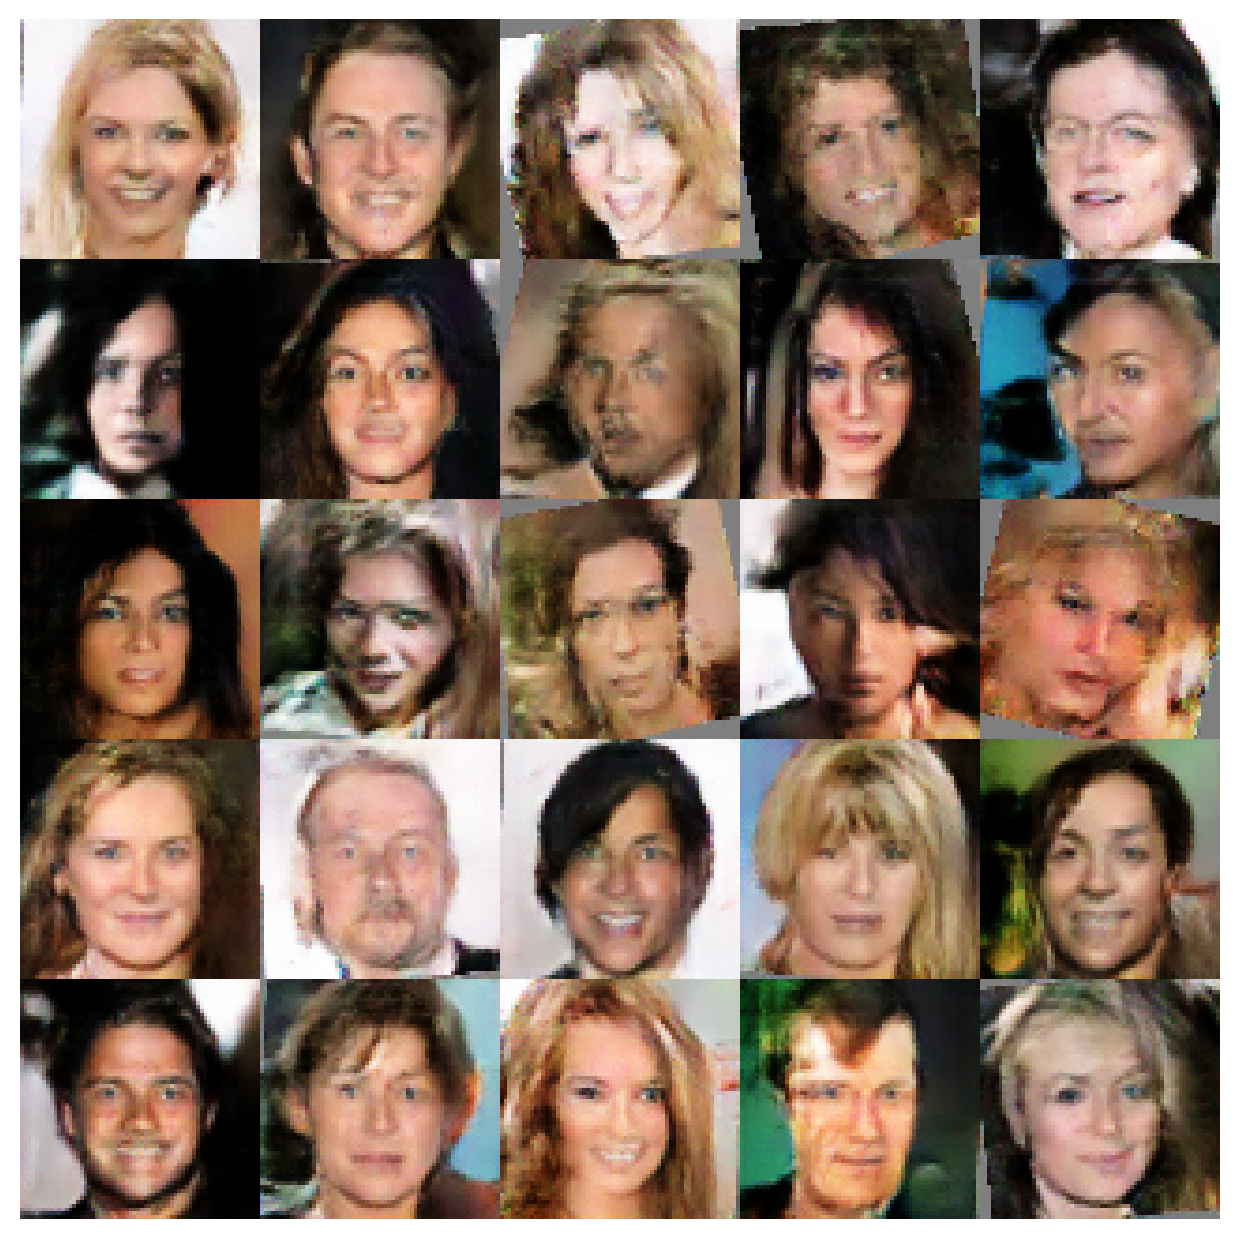

In [23]:
noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
fake_imgs = G(noise).detach().cpu()

fig, axs = plt.subplots(5, 5, figsize=(6,6))
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
axs = axs.flatten()
for i in range(25):
    axs[i].imshow(inverse_normalize(fake_imgs[i]).permute(1,2,0))
    axs[i].axis('off')
plt.show()